In [76]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from ASHRAE_tools import meter_dict
from zipfile import ZipFile
from pandas.plotting import scatter_matrix

meter_dict = meter_dict()

## Load Data

In [3]:
if not os.path.exists('data'):
    os.makedirs('data')


In [4]:
#! kaggle competitions download -c ashrae-energy-prediction -p ./data

In [5]:
#zf = ZipFile("./data/ashrae-energy-prediction.zip")
#zf.extractall(path = './data')
#zf.close()

## EDA Train Data

In [120]:
train = pd.read_csv('./data/train.csv')
building_metadata = pd.read_csv('./data/building_metadata.csv')

In [3]:
train.shape

(15162075, 4)

In [4]:
train.head()

,building_id,meter,timestamp,meter_reading
7015320,914,2,2016-05-10 18:00:00,122.0000
413213,1300,0,2016-01-08 11:00:00,50.6891
4053667,18,0,2016-03-17 21:00:00,0.0000
6820221,515,0,2016-05-07 07:00:00,50.3400
19281929,581,0,2016-12-15 12:00:00,16.3250


In [9]:
train.dtypes

building_id        int64
meter              int64
timestamp         object
meter_reading    float64
dtype: object

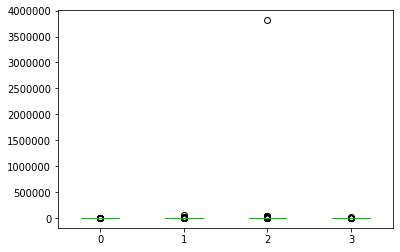

In [39]:
train.pivot_table(values='meter_reading',index='building_id',columns='meter',aggfunc=np.mean).plot.box()
plt.show()

En la gráfica de arriba se ve un punto atípico. Eliminaremos todas las medidas mayores a *1,000,000kWh*

In [111]:
train.loc[(train['meter_reading']>100000)].groupby('building_id').count()

,meter,timestamp,meter_reading
building_id,,,
60,1,1,1
778,837,837,837
954,1,1,1
993,1,1,1
1021,52,52,52
1088,311,311,311
1099,3265,3265,3265
1159,2,2,2
1168,552,552,552


In [108]:
building_metadata.loc[building_metadata['building_id']==1099]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1099,13,1099,Education,332884,NaN,NaN


In [106]:
building_metadata.sort_values('square_feet', ascending=False).head(70)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
869,8,869,Entertainment/public assembly,875000,NaN,1.0
1148,13,1148,Office,861524,NaN,NaN
375,3,375,Office,850354,1989.0,NaN
365,3,365,Healthcare,819577,1922.0,NaN
269,2,269,Entertainment/public assembly,809530,1958.0,NaN
797,7,797,Education,764237,1979.0,13.0
927,9,927,Lodging/residential,745671,NaN,NaN
794,7,794,Education,731945,1969.0,11.0
1108,13,1108,Parking,679614,NaN,NaN
1159,13,1159,Office,671507,NaN,NaN


In [121]:
train.loc[(train['meter_reading']>100000),'meter_reading'] = -1

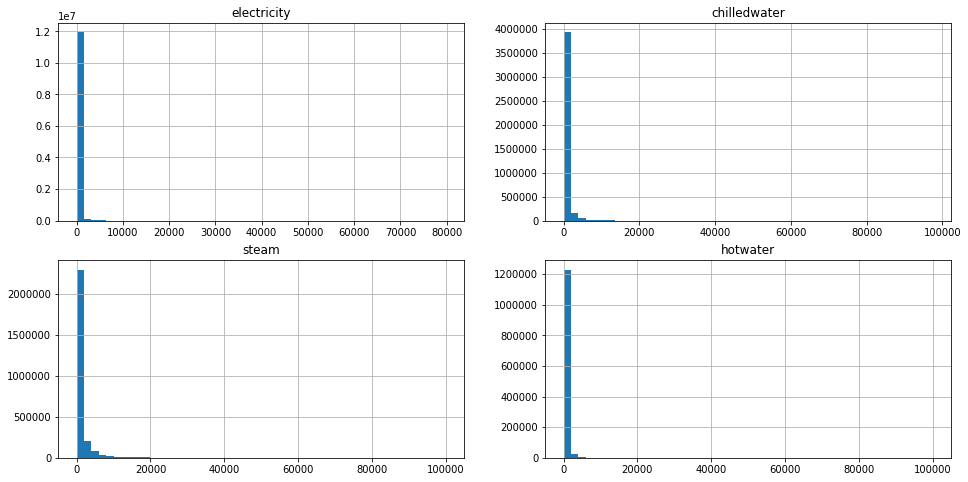

In [122]:
#plt.rcParams["figure.figsize"] = (16,8)

plt.subplot(221)
train.loc[train['meter']==0].meter_reading.hist(bins=50, figsize = (16,8))
plt.title(meter_dict[0])
plt.grid(True)

plt.subplot(222)
train.loc[train['meter']==1].meter_reading.hist(bins=50, figsize = (16,8))
plt.title(meter_dict[1])

plt.subplot(223)
train.loc[train['meter']==2].meter_reading.hist(bins=50, figsize = (16,8))
plt.title(meter_dict[2])

plt.subplot(224)
train.loc[train['meter']==3].meter_reading.hist(bins=50, figsize = (16,8))
plt.title(meter_dict[3])

plt.show()

In [61]:
train.groupby('meter').size()

meter
0    12060910
1     4182440
2     2705646
3     1264037
dtype: int64

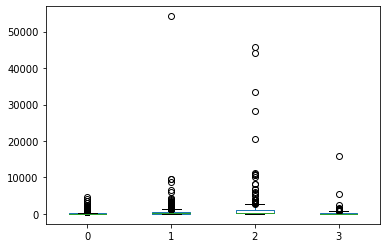

In [62]:
train.pivot_table(values='meter_reading',index='building_id',columns='meter',aggfunc=np.mean).plot.box()
plt.show()

## Analiza weather data

In [63]:
weather_train = pd.read_csv('./data/weather_train.csv')

In [64]:
weather_train.shape

(139773, 9)

In [65]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [66]:
weather_train.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000
mean,7.478977,14.418106,2.149306,7.350158,0.983047,1016.158038,180.526632,3.560527
std,4.604744,10.626595,2.599150,9.790235,8.463678,7.629684,111.523629,2.335874
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.800000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,11.000000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


## EDA Metadata

In [68]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [69]:
building_metadata.groupby('site_id').size()
#building_metadata.groupby('primary_use').size()

site_id
0     105
1      51
2     135
3     274
4      91
5      89
6      44
7      15
8      70
9     124
10     30
11      5
12     36
13    154
14    102
15    124
dtype: int64

In [70]:
building_metadata.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


La tabla metadata tiene una observación por cada *building*

## Tidy train data

In [123]:
tidy_train = train.join(building_metadata, on = 'building_id', lsuffix = '_', rsuffix = '_meta')
tidy_train.drop('building_id_meta', inplace=True, axis=1)

In [114]:
tidy_train.head()

,building_id_,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,-1,-1,-1,-1.0,NaN,NaN,NaN,NaN,NaN
1,-1,-1,-1,-1.0,NaN,NaN,NaN,NaN,NaN
2,-1,-1,-1,-1.0,NaN,NaN,NaN,NaN,NaN
3,-1,-1,-1,-1.0,NaN,NaN,NaN,NaN,NaN
4,-1,-1,-1,-1.0,NaN,NaN,NaN,NaN,NaN


In [124]:
tidy_train = tidy_train.merge(weather_train, on = ['site_id','timestamp'], how='left')
tidy_train['timestamp'] = pd.to_datetime(tidy_train['timestamp'])

In [74]:
tidy_train.head()

,building_id_,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


## EDA Total

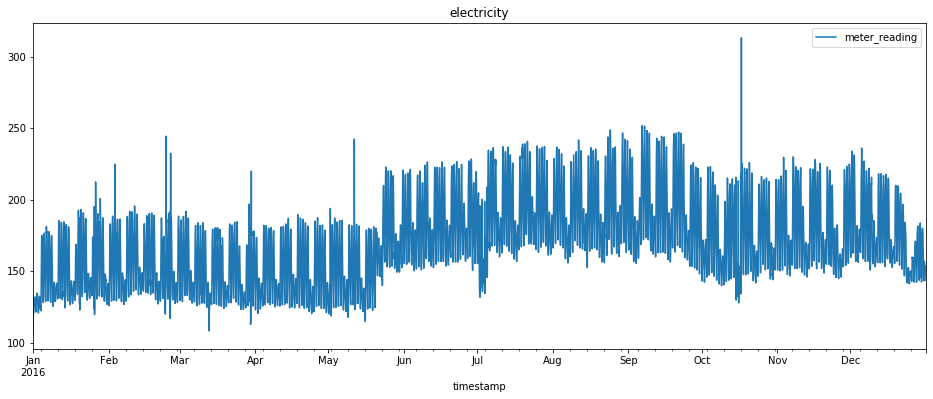

In [125]:
tidy_train.loc[tidy_train['meter']==0,['timestamp','meter_reading']].groupby('timestamp').mean().plot(figsize = (16,6))
plt.title(meter_dict[0])

plt.show()

Text(0.5, 1.0, 'chilledwater')

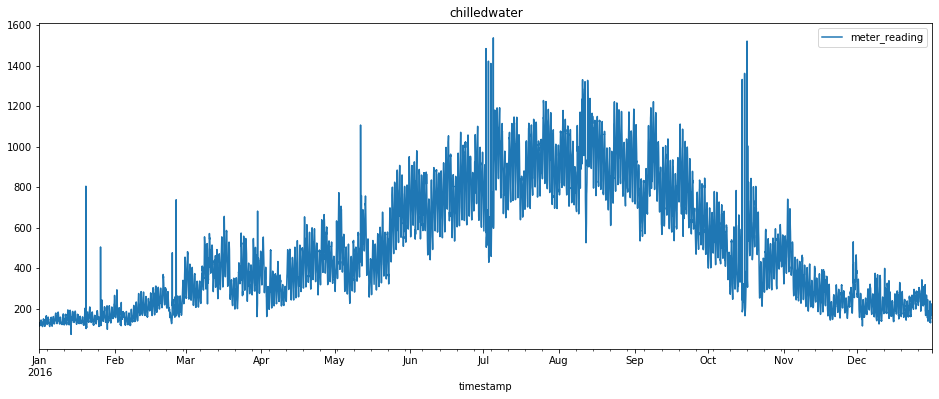

In [126]:
tidy_train.loc[tidy_train['meter']==1,['timestamp','meter_reading']].groupby('timestamp').mean().plot(figsize = (16,6))
plt.title(meter_dict[1])
#plt.show()

Text(0.5, 1.0, 'steam')

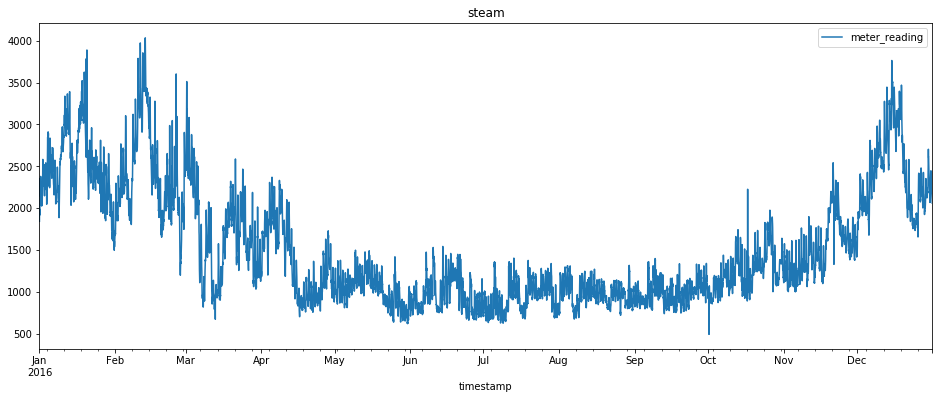

In [127]:
tidy_train.loc[tidy_train['meter']==2,['timestamp','meter_reading']].groupby('timestamp').mean().plot(figsize = (16,6))
plt.title(meter_dict[2])
#plt.show()

Text(0.5, 1.0, 'hotwater')

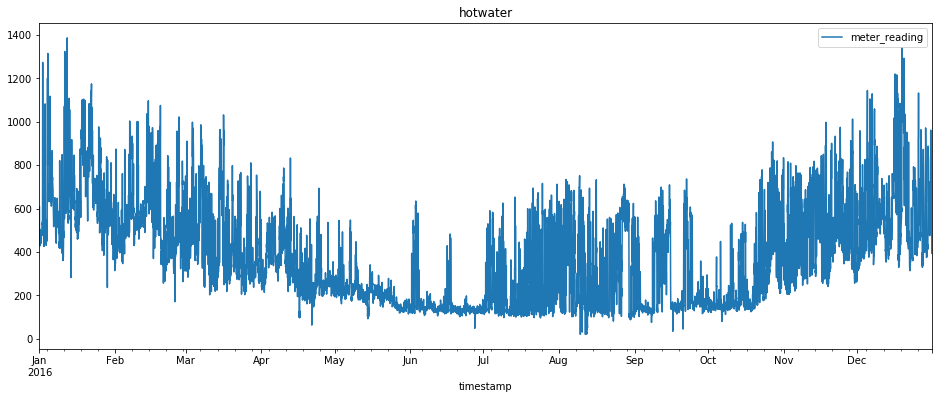

In [128]:
tidy_train.loc[tidy_train['meter']==3,['timestamp','meter_reading']].groupby('timestamp').mean().plot(figsize = (16,6))
plt.title(meter_dict[3])


In [129]:
#scatter_matrix(tidy_train.iloc[:,[1,3,4,6,7,8,9,10,11,12,13,14,15]])

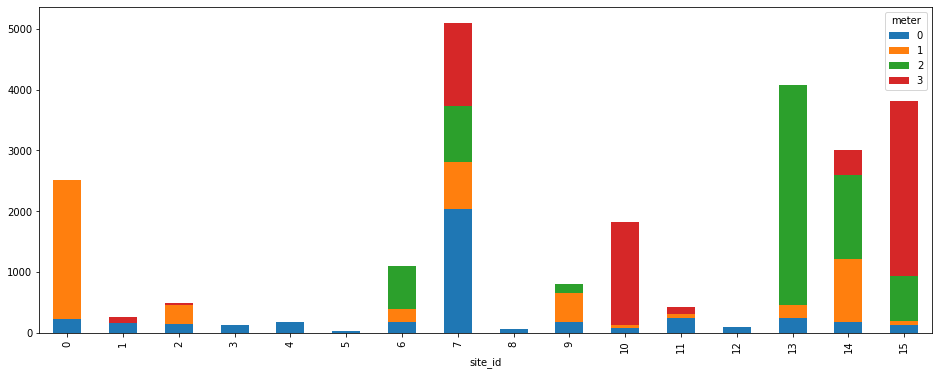

In [130]:
tidy_train.loc[:,['meter','site_id','meter_reading']].pivot_table(values='meter_reading',index='site_id',columns='meter',aggfunc=np.mean).plot.bar(stacked=True,figsize = (16,6))
plt.show()

El sitio que más concentra consumo electrico es el 13, y de este, la mayoría es del tipo *steam*.

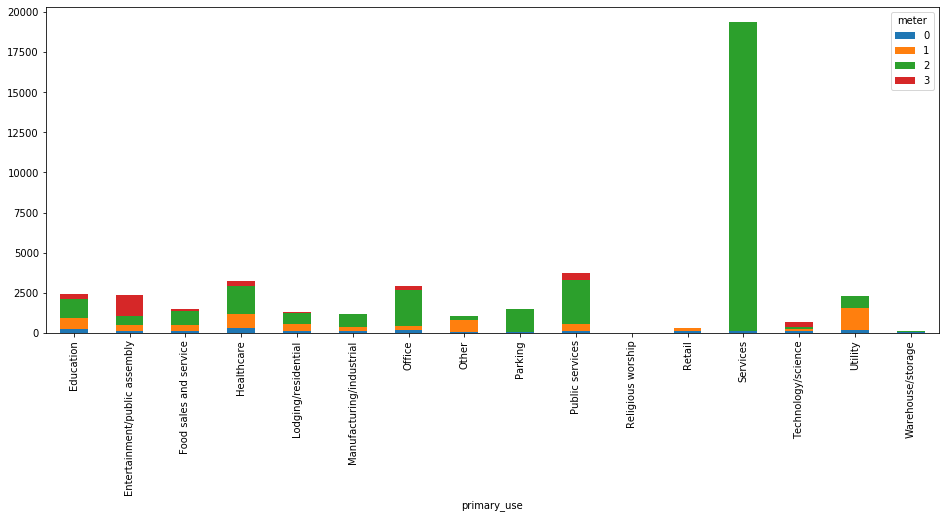

In [131]:
tidy_train.loc[:,['meter','primary_use','meter_reading']].pivot_table(values='meter_reading',index='primary_use',columns='meter',aggfunc=np.mean).plot.bar(stacked=True,figsize = (16,6))
plt.show()

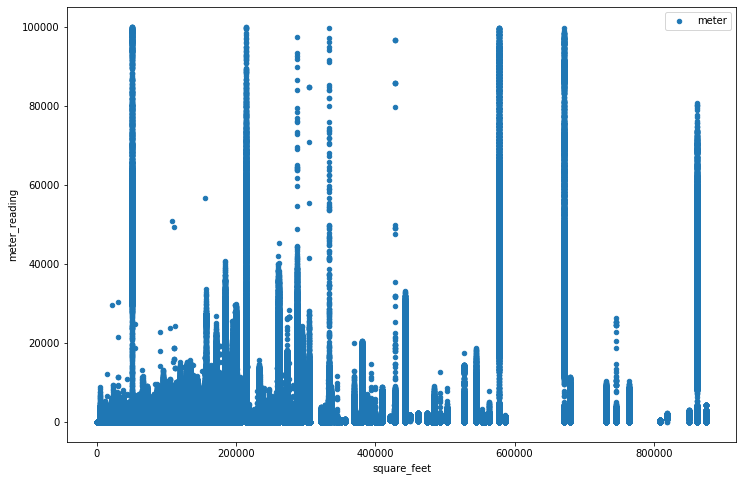

In [132]:
tidy_train.loc[:,['square_feet','meter_reading','meter']].plot.scatter(x = 'square_feet', y = 'meter_reading', label = 'meter',figsize = (12,8))

Esta gráfica no nos dice mucha información, así que la agruparemos por dia